In [23]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [24]:
#testing parallel run of shorter simulations for Gershman 09's model

In [25]:
#parallisation on Gershman 09's model
#p: no. simulations running in parallel
def likelihood_new(z,a,b,sigma,p):
    #bi-modal, mixture of Gaussian function
    #2 peaks at -1 and 1
    #return: a scalar, p(x|z) as a functino of z
    likelihood_ele = np.exp(-0.5/sigma**2*(z.reshape((p,-1))-a)**2) + np.exp(-0.5/sigma**2*(z.reshape((p,-1))-b)**2)
    return np.prod(likelihood_ele,axis=1)

In [26]:
def proposal_function_new(z, p, sigma1 = 1.5):
    #generate a new proposal from the current sample
    #change only one element at a time!
    dim = z.shape[1]
    z_star = z.copy()
    i = random.randint(0,dim)
    j = random.randint(0,dim)
    index = random.randint(0,dim,(p,2))
    for i in range(p):
        z_star[i,index[i,0],index[i,1]] = z_star[i,index[i,0],index[i,1]] + sigma1*np.random.normal()
    return z_star

In [27]:
def MRF_prior_new(z,lamda,p):
    #return the Gaussian MRF of the perception
    #'reflection on boundary first
    dim = z.shape[1]
    z_extended = np.concatenate((z[:,:,0].reshape(p,-1,1),z,z[:,:,-1].reshape(p,-1,1)),axis=2)
    z_extended = np.concatenate((z_extended[:,0,:].reshape(p,1,-1),z_extended,z_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    sum_dis = np.sum(np.sum((z-z_extended[:,:dim,1:dim+1])**2,axis=1),axis=1)+np.sum(np.sum((z-z_extended[:,2:,1:dim+1])**2,axis=1),axis=1)
    sum_dis = sum_dis+np.sum(np.sum((z-z_extended[:,1:dim+1,:dim])**2,axis=1),axis=1)+np.sum(np.sum((z-z_extended[:,1:dim+1:,2:])**2,axis=1),axis=1)
    return np.exp(-lamda*sum_dis)

In [28]:
def sample_rejection_new(z,z_star,p,a = 1, b = -1, sigma = 0.3, lamda = 0.05):
    #input: z is the current sample
    #z_star is the proposed sample
    #if sample accepted: return True
    #if rejected: return False
    p_z = likelihood_new(z,a,b,sigma,p)*MRF_prior_new(z,lamda,p)
    p_z_star = likelihood_new(z_star,a,b,sigma,p)*MRF_prior_new(z_star,lamda,p)
    p_acc = p_z_star/p_z
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [29]:
def simulation(p,no_samples,a = 1, b = -1, sigma = 0.3, lamda = 0.05,dim = 4):
    state_list_par = []
    #define initial z
    z = (np.random.rand(p,dim,dim)-0.5)*2
    for i in range(int(no_samples)):
        z_star = proposal_function_new(z,p)
        acc = sample_rejection_new(z,z_star,p,a, b, sigma, lamda)
        for j in range(p):
            if acc[j] == 1:
                z[j,:,:] = z_star[j,:,:]
        z_a = z.copy()
        state_list_par.append(z_a)
    return state_list_par

In [30]:
p,no_samples = 300,88000
s = simulation(p,no_samples,a = 1, b = -1, sigma = 0.16, lamda = 0.08,dim = 4)
s = np.array(s)

In [31]:
s_test = s[:,99,:,:]
print(s.shape)
state_num_test = np.array([len(np.where(state>0)[0]) for state in s_test])

s_test1 = np.array(s)[:,9,:,:]
state_num_test1 = np.array([len(np.where(state>0)[0]) for state in s_test1])

(88000, 300, 4, 4)


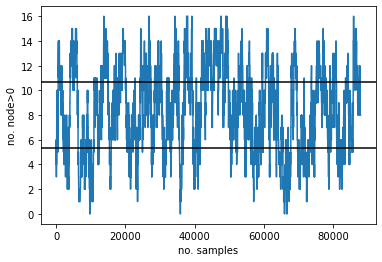

In [32]:
plt.plot(state_num_test)
plt.xlabel('no. samples')
plt.ylabel('no. node>0')
plt.axhline(y=16/3, color = 'k')
plt.axhline(y=32/3,color = 'k')

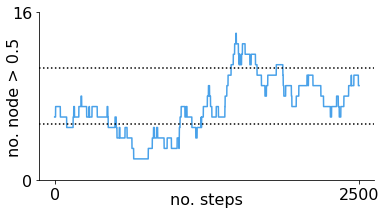

In [65]:
fig,ax = plt.subplots(1)
ax.plot(np.array([len(np.where(state>0)[0]) for state in s[:,10,:,:]])[400:2900],color='#1b8ae4',alpha=0.8)
ax.set_box_aspect(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,2500])
ax.set_yticks([0,16])
ax.axhline(y=16/3,ls='dotted',color = 'black')
ax.axhline(y=32/3,ls='dotted',color = 'black')
ax.set_xlabel('no. steps',labelpad=-10)
ax.set_ylabel('no. node > 0.5',labelpad=-10)
fig.savefig('2009.svg')
plt.rcParams['font.size'] = '16'

In [33]:
def corr(x,y):
    return (np.mean(x*y)-np.mean(x)*np.mean(y))/(np.var(x)*np.var(y))**0.5
def autocorr(x,y,n):
    #x, y: arrays to calculate correlation
    #n: cover correlation rxy(0) to rxy(n-1)
    rxy = []
    for i in range(n):
        y_shift = np.concatenate((np.zeros(i),y[:(len(y)-i)]))
        rxy.append(corr(x,y_shift))
    return np.array(rxy)

In [34]:
'''corr_list = []
p = 400
s = np.array(s)
for i in range(p):
    corr_list.append(corr(s[:,0,3,1],s[:,i,3,1]))
corr_list = np.array(corr_list)'''

'corr_list = []\np = 400\ns = np.array(s)\nfor i in range(p):\n    corr_list.append(corr(s[:,0,3,1],s[:,i,3,1]))\ncorr_list = np.array(corr_list)'

In [35]:
'''plt.plot(np.arange(400),corr_list)
plt.xlabel('no. sampling sequence')
plt.ylabel('correlation')
plt.title('correlation between sampling sequence 0 and other sequences')
print(np.max(corr_list[1:]))'''

"plt.plot(np.arange(400),corr_list)\nplt.xlabel('no. sampling sequence')\nplt.ylabel('correlation')\nplt.title('correlation between sampling sequence 0 and other sequences')\nprint(np.max(corr_list[1:]))"

In [36]:
'''autocorr_s = autocorr(s[:,0,2,1],s[:,0,2,1],600)
for i in range(1,400):
    autocorr_s = autocorr_s + autocorr(s[:,i,2,1],s[:,i,2,1],600)
autocorr_s = autocorr_s/400'''

'autocorr_s = autocorr(s[:,0,2,1],s[:,0,2,1],600)\nfor i in range(1,400):\n    autocorr_s = autocorr_s + autocorr(s[:,i,2,1],s[:,i,2,1],600)\nautocorr_s = autocorr_s/400'

In [37]:
'''plt.plot(autocorr_s)
plt.xlabel('discrete time (no.step)')
plt.ylabel('correlation')
plt.title('autocorrelogram')
plt.axhline(y=0.05, color='r', linestyle='-')
for i in range(len(autocorr_s)):
    if autocorr_s[i]<0.05:
        print(i)
        break'''

"plt.plot(autocorr_s)\nplt.xlabel('discrete time (no.step)')\nplt.ylabel('correlation')\nplt.title('autocorrelogram')\nplt.axhline(y=0.05, color='r', linestyle='-')\nfor i in range(len(autocorr_s)):\n    if autocorr_s[i]<0.05:\n        print(i)\n        break"

In [48]:
#from node's state to the no. node > 0 in each step
state_no_array = []
for i in range(p):
    state_no_array_i = []
    for j in range(no_samples):
        state_no_array_i.append(len(np.where(s[j,i,:,:]>0)[0]))
    state_no_array.append(state_no_array_i)
state_no_array = np.array(state_no_array)

In [39]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>1/3*dim**2 and state_list_input[i]<1/3*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<2/3*dim**2 and state_list_input[i]>2/3*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

In [40]:
domi_list = []
for state_list_i in state_no_array:
    domi_list = domi_list + domi_period_count(state_list_i,4)

(1491.1871109266615, 1356.7239614161595)

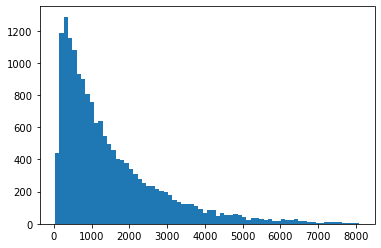

In [41]:
domi_list = np.array(domi_list)
domi_list = np.sort(domi_list)
domi_list.shape
hist_plot(domi_list[:-80],70)

[1.46836055 0.64108456 2.12241611]


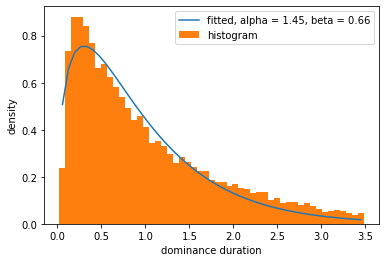

In [54]:
from scipy.optimize import curve_fit
y,bins=np.histogram(domi_list[:-800]/np.mean(domi_list[:-800]),50,density=True)
x = []
for i in range(1,51):
    x.append((bins[i]+bins[i-1])/2)
x=np.array(x)

def gamma(x,a,b,c):
    return c*np.exp(-x/b)*x**(a-1)

popt,pcov = curve_fit(gamma,x,y)

plt.plot(x,gamma(x,popt[0],popt[1],popt[2]))
plt.hist(domi_list[:-800]/np.mean(domi_list[:-800]),51,density=True)

plt.xlabel('dominance duration')
plt.ylabel('density')
plt.legend(['fitted, alpha = 1.45, beta = 0.66','histogram'])

print(popt)

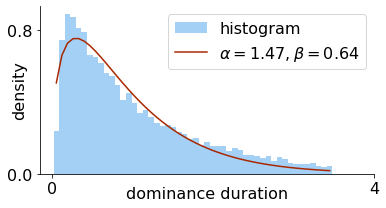

In [59]:
fig,ax = plt.subplots(1)
ax.hist(domi_list[:-800]/np.mean(domi_list[:-800]),50,density=True,alpha=0.4,color='#1b8ae4',label = 'histogram')
ax.plot(x,gamma(x,popt[0],popt[1],popt[2]),color = '#a82700',label = r'$\alpha=1.47,\beta=0.64$')
ax.set_box_aspect(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,4])
ax.set_yticks([0,0.8])
ax.set_xlabel('dominance duration',labelpad=-10)
ax.set_ylabel('density',labelpad=-20)
ax.legend()
fig.savefig('domi_2009.svg')
plt.rcParams['font.size'] = '16'

Text(0, 0.5, 'density')

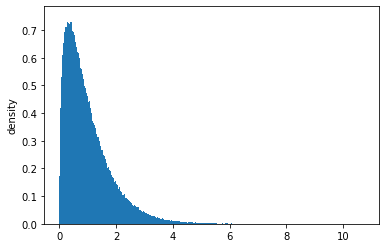

In [43]:
plt.hist(random.gamma(1.45,0.69,1000000),1000,density=True)
plt.ylabel('density')